# Variational Autoencoder for MNIST

An autoencoder is a type of neural network in which the input is the same as the output. The hidden layers are of lower dimmension than the output so the network is optimized to compress the input and reconstruct it from that compression. The two components of an AE are the encoder and the decoder.

A traditional autoencoder feeds the encoders input directly into the decoder. Where a Variational Autoencoder differs is that the latent representation output by the encoder is then used to define a gaussian distribution based on its mean and log(variance). A random sampling of this distrubution is used as input into the decoder. 

The VAE uses two loss functions in the optimization process. The first is the reconstruction loss which determines how well the model compresses and reconstructs. The second is the KL Divergence loss which acts as a penalty added to the reconstruction loss to determine how different the gaussian distribution defined by the latent representation is from the standard normal distribution.

As a result of the added stochasitcity of randomly sampling the latent distribution, the decoder is endowed with generative capabilities. This manifests when the decoder is given an input that is a random sampling from the standard normal distribution. As a result of the KL Divergence penalty the decoder is capable of generating new samples from this input.


In this notebook I implement a variational autoencoder for mnist.

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

Below I load in the mnist dataset, transform to tensors from PIL, and then create a dataloader for the training and test sets.

In [44]:
# Define a transform to convert the PIL images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset with the transformation
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap in a DataLoader
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=128, shuffle=True)


Here is a plot of a few examples

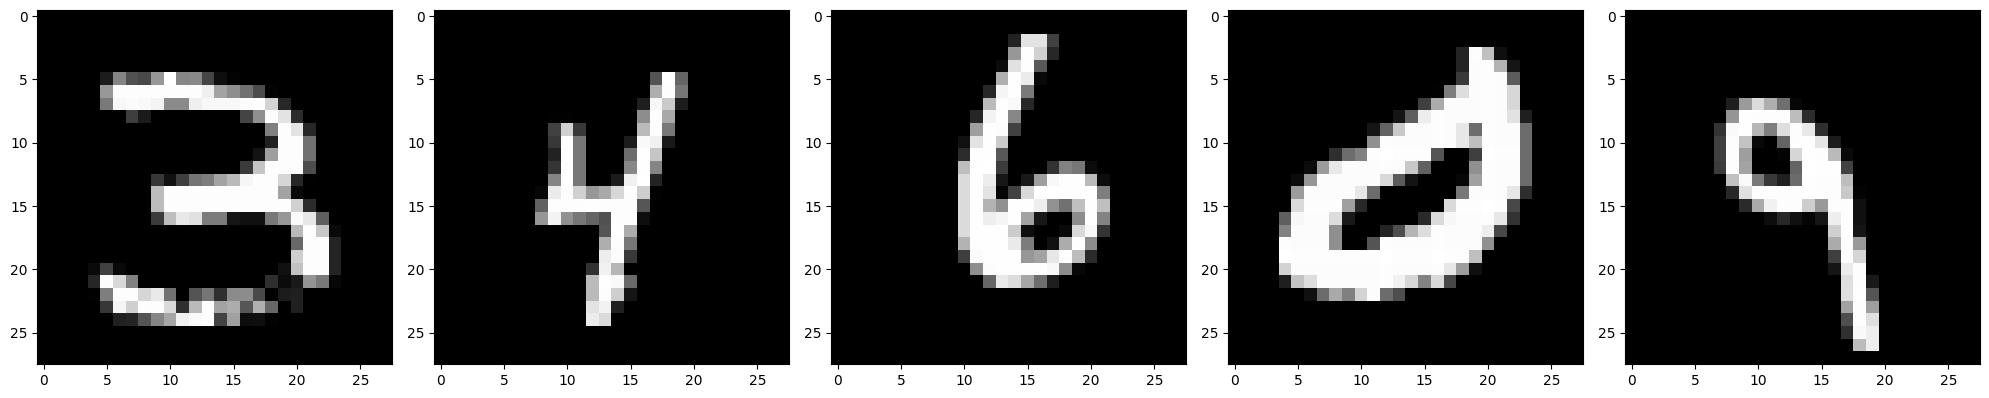

(None, None)

In [45]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    data_iter = iter(train_loader)
    image = next(data_iter)
    image = image[0][0].transpose(0, 1).transpose(1, 2) # transpose image[0][0] such that the first dimension is the channel and the second and third dimensions are the height and width.

    #plot image
    ax[i].imshow(image, cmap='gray')
plt.tight_layout(), plt.show()

# Model

Below is defined the VAE

The input is fed to the encoder. The encoder ouputs the mean and log of the variance. These values are used to define a normal distribution and return a random sampling from it in the reparametrize() method. This is known as the reparametrization trick of Variation Autoencoders. It adds stochasticity to the model, leading to more diverse generative abilities in the decoder. Additionally, it allows the gradients to influence this sampling process by adjusting the normal distribution's definition during optimization. Had this been implemented inside the encoder or decoder, the stochasticity would negatively affect the gradient based optimization of backpropagation. The sampling of the distrubution is then fed into the decoder, which outputs the reconstructed image.

In [46]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Separate layers for computing mean and log variance in the Latent space
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid() #sigmoid outputs to [0,1]
        )
    
    def reparametrize(self, mu, logvar):
        '''
        With the mean and the std of the encoded input,transform aa sample of the standard 
        normal distribution N(), 1) to the distribution of the encoded input by z = mu + std*eps
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x) #encode the input
        mu, logvar = self.mu(encoded), self.logvar(encoded) #get the mean and the log of the variance
        reparametrized = self.reparametrize(mu, logvar) #reparametrize
        decoded = self.decoder(reparametrized) #decode the reparametrized latent
        return decoded, mu, logvar
    
    def loss(self, input, decoded, mu, logvar):
        '''
        The KL divergence loss measures the difference between the standard
        normal distribution and the distribution defined by the encoder 
        output's mean and variance. The reconstruction loss measures the
        difference between the decoded output and the input.
        '''
        recon_loss = F.binary_cross_entropy(decoded, input, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return recon_loss + kl_divergence #total loss

# Training Loop

Below we initialize the model and run the trianing loop. Early stopping is used to determine the number of epochs. 

In [53]:
vae = VAE(784, 300, 20)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Data will be loaded to: {device}')

epochs = 1000

#early stopping
patience, counter, min_loss = 5, 0, np.Inf

for epoch in range(epochs):
    for i, (data, _) in enumerate(train_loader):
        inputs = data.to(device).view(-1, 784)  # Move tensor to device and  Reshape the inputs to (batch_size, 784)

        decoded, mu, logvar = vae(inputs)
        loss = vae.loss(inputs, decoded, mu, logvar)

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate
        optimizer.step()  # Update the weights

    decoded, mu, logvar = vae(inputs)
    loss = vae.loss(inputs, decoded, mu, logvar)
    
    if epoch % 5 == 0 or epoch == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f}')

    #early stopping
    if loss.item() < min_loss:
        min_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch: {epoch} \nFinal Loss was {loss.item():.4f}')
            break

Data will be loaded to: cpu
Epoch: 0, Loss: 13306.7910
Epoch: 5, Loss: 10635.9248
Epoch: 10, Loss: 10173.2305
Epoch: 15, Loss: 9940.3291
Epoch: 20, Loss: 9232.8301
Early stopping at epoch: 23 
Final Loss was 9741.3945


Below is a plot of 5 examples, their input into the VAE, their latent distribution, their output. 

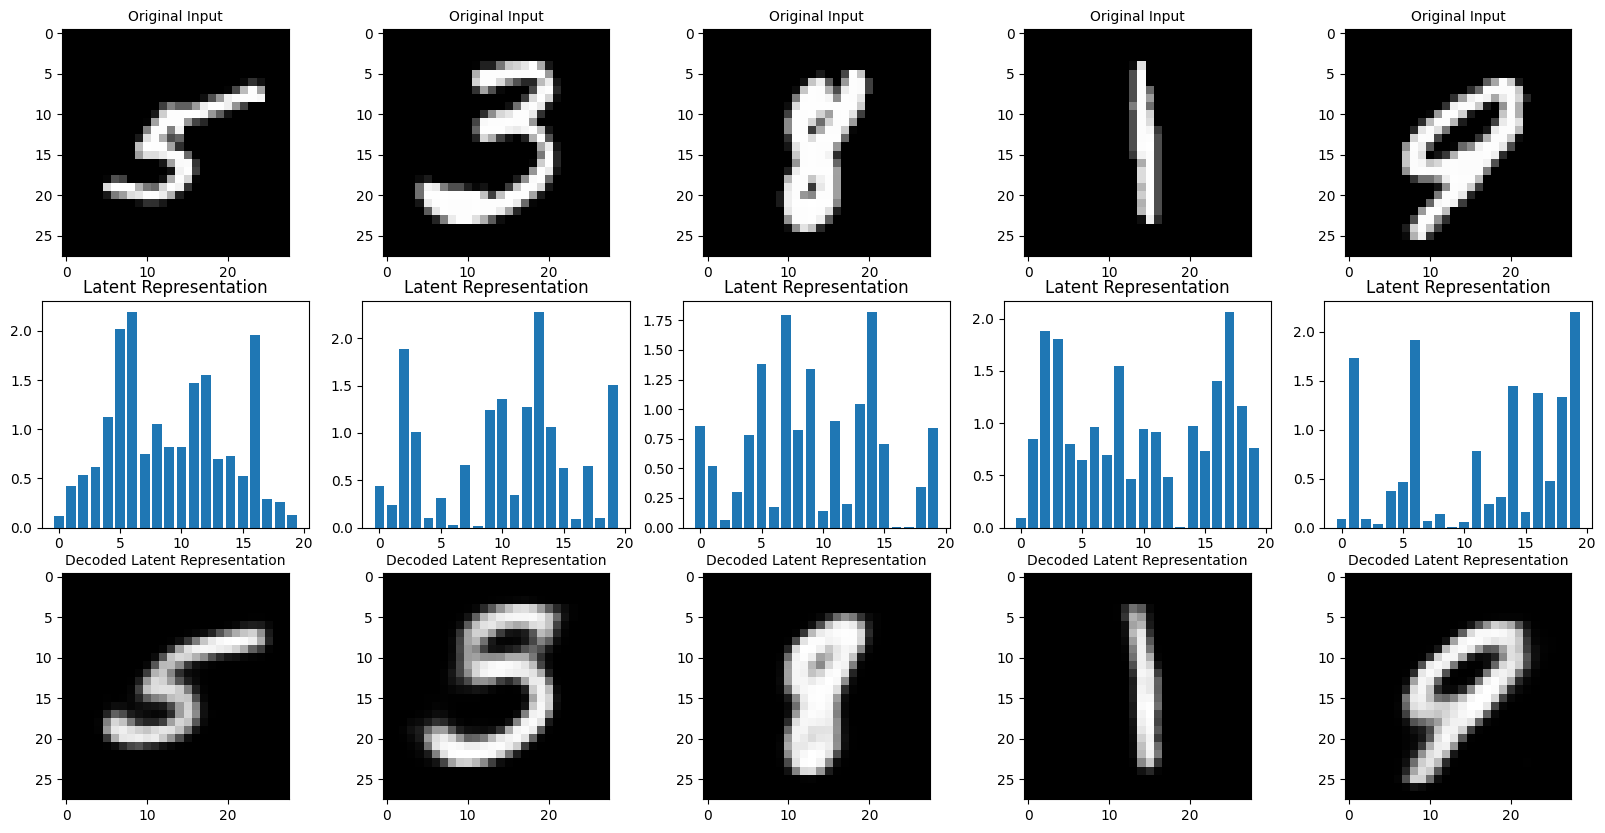

In [57]:
decoded, mu, logvar = vae(inputs)

fig, ax = plt.subplots(3, 5, figsize=(20, 10))
for i in range(5):
    #original image
    image = inputs[i].cpu().view(28, 28).detach().numpy()
    ax[0][i].imshow(image, cmap='gray')
    #set title of each subplot
    ax[0][i].set_title("Original Input", fontsize=10)

    #latent representation
    z = vae.reparametrize(mu[i], logvar[i]).detach().cpu().numpy()
    ax[1][i].bar(range(20), np.abs(z))
    ax[1][i].set_title("Latent Representation")

    #decoded image
    image = decoded[i].cpu().view(28, 28).detach().numpy()
    ax[2][i].imshow(image, cmap='gray')
    ax[2][i].set_title("Decoded Latent Representation", fontsize=10)



Below I take a random sampling of the standard normal distribution and feed it into the decoder. 

In [58]:
standard_sample = torch.randn(64, 20).to(device) # Generate a random tensor of size (64, 20)
generated = vae.decoder(standard_sample) # Pass the random tensor through the decoder

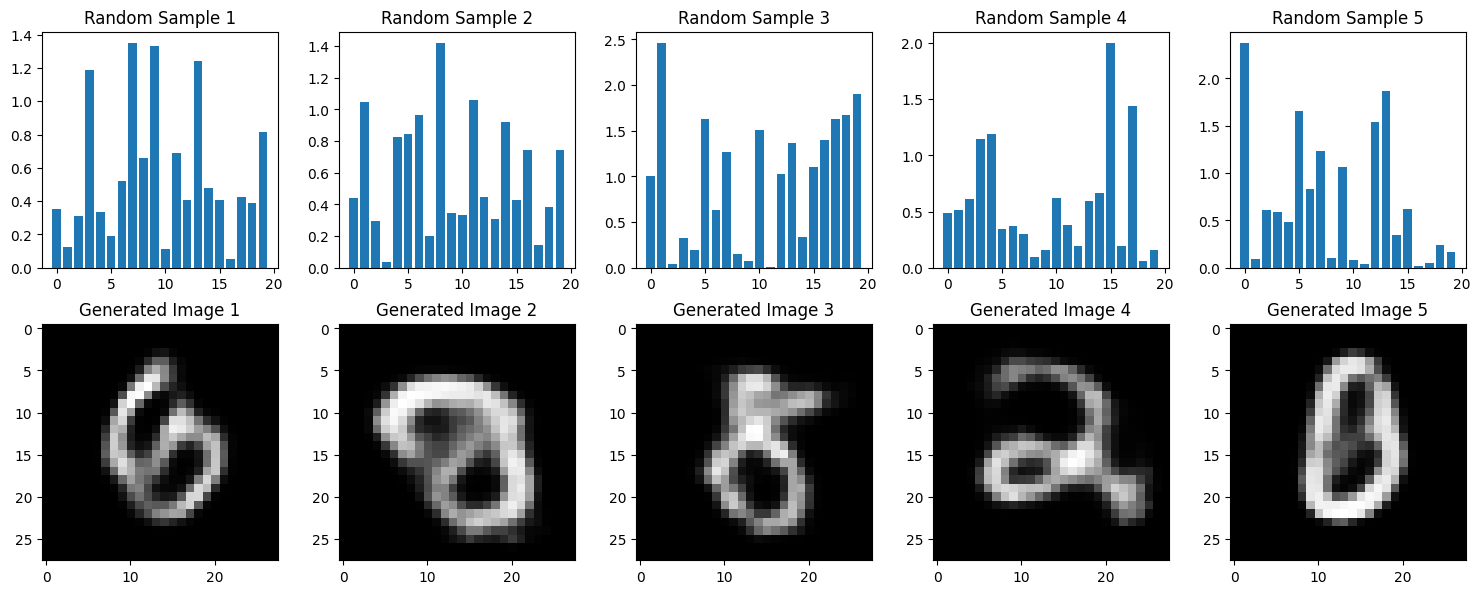

In [63]:
fig, axs = plt.subplots(2, 5, figsize=(15,6)) 

# Reshape the generated data back into images
generated_images = generated.view(-1, 28, 28).cpu().detach().numpy()

# Plotting the random samples
for i, ax in enumerate(axs[0]):
    ax.bar(np.arange(20), np.abs(standard_sample[i].cpu().numpy()))
    ax.set_title(f"Random Sample {i+1}")

# Plotting the generated images
for i, ax in enumerate(axs[1]):
    ax.imshow(generated_images[i], cmap='gray')
    ax.set_title(f"Generated Image {i+1}")

plt.tight_layout()
plt.show()


This plot of the images reveals how well the generative capabilities are.